<a href="https://colab.research.google.com/github/aviax1/AE1/blob/master/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**dependencies**

In [ ]:
!pip install wandb
import torch,wandb,os
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from tensorflow.keras.datasets import mnist
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

**initial**

In [19]:
(xtrain,ytrain), (xtest,ytest) = mnist.load_data()
num_epochs=1000        #
batch_size = 64        #
image_size=784         #
hidden_size=64         #
lv_size = 64           # Latent Variable 
learning_rate=1e-3 #
cret = nn.MSELoss()    # criterion

**build model**

In [20]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, hidden_size),   #nn.ReLU(True), nn.Linear(image_size, hidden_size),nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True), nn.Linear(hidden_size, hidden_size), nn.ReLU(True), nn.Linear(hidden_size, lv_size))
        self.decoder = nn.Sequential(
            nn.Linear(lv_size, hidden_size),nn.ReLU(True),nn.Linear(hidden_size, hidden_size),nn.ReLU(True), nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),nn.Linear(hidden_size, hidden_size),nn.ReLU(True), nn.Linear(hidden_size, image_size), nn.Tanh())

    def forward(self, x):
        return self.decoder(self.encoder(x))

**model setting**

In [21]:
model = autoencoder()
tmodel=autoencoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

class DigitDataSet(Dataset):
  def __init__(self, dataset):
      self.dataset = dataset
      self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      return self.transform( self.dataset[idx,:,:])

**classsifcation by train models**

In [22]:
def testmodel(): 
  nn=len(ytest)
  dataloader = DataLoader(DigitDataSet(xtest), batch_size=nn,shuffle=0 , num_workers=4)
  diff = np.zeros( (nn,10),dtype=np.float32 )
  for i in range(10):
    for data in dataloader:
      input_imgs = data
      imgs = Variable(input_imgs.view(input_imgs.size(0), -1))
      model_name='./ae_'+str(i)+'.pth'
      tmodel.load_state_dict(torch.load(model_name))
      tmodel.eval()
      output_imgs = tmodel(imgs)
      for i2 in range(len( output_imgs[:,0])):
        im_pred=output_imgs.detach().numpy()[i2,:]
        im_org=imgs.numpy()[i2,:]
        difmat=np.abs(im_pred.reshape(28,28)-im_org.reshape(28,28))
        diff[i2,i]=np.sum( np.sum( difmat ))
  min_index=np.argmin(diff, axis=1)
  seccess =  min_index == ytest
  counts, bins = np.histogram(ytest[ min_index != ytest ])
  plt.hist(bins[:-1], bins, weights=counts)
  plt.title("error by digit")
  plt.show()
  accurcy =int(10000*np.sum(seccess))/(nn*100)
  error_rate = int(10000*np.sum(min_index != ytest))/(nn*100)
  print(str(accurcy) + "% accuracy or "+str(error_rate)+"% error rate")

**train model by digit**

In [ ]:
def save_model(digit,model):
  model_name='./ae_'+str(digit)+'.pth'
  torch.save(model.state_dict(),model_name )
  wandb.save(model_name)
  print("save model "+ model_name)

def load_model_ifexist(digit,model):
  model_name='./ae_'+str(digit)+'.pth'
  if os.path.isfile(model_name):
    model.load_state_dict(torch.load(model_name))
    model.eval()
  return model

def train_by_digit(by_digit,model):
  model=load_model_ifexist( by_digit,model)
  wandb.init()
  print("*****\nstart traning Model for digit " +str(by_digit) +"\n")
  dataloader = DataLoader(DigitDataSet(xtrain[ytrain==by_digit]), batch_size=batch_size,shuffle=True, num_workers=6)
  for epoch in range(num_epochs):
    run=  epoch%25==0
    run2= epoch%125==0 and epoch >0
    for data in dataloader:
      imgs = Variable(data.view(data.size(0), -1))
      output_imgs = model(imgs)
      loss = cret(output_imgs, imgs)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if run:
        run=0
        im=data[0,0,:,:].reshape(28,28)
        pred=model(imgs).detach().numpy()[0,:].reshape(28,28)
        wandb.log({"img": [wandb.Image(pred, caption="preidciton"),wandb.Image(im, caption="original")]})
      if run2:
        run2=0
        save_model(by_digit,model)
        #testmodel()
        
    print('epoch [{}/{}], loss:{:.4f}' .format(epoch + 1, num_epochs, loss.data))
    wandb.log({"loss": loss.data})
  save_model(by_digit,model)
  print("\nfinish traning Model Number " +str(by_digit) +"\n*****\n")

for by_digit in range(5,10):
  train_by_digit(by_digit,model)

**or used our train model**

In [ ]:
!git clone https://github.com/aviax1/AE1/
!unzip ./AE1/models.zip -d ./
!rm -rf ./AE1

**finaly test model**

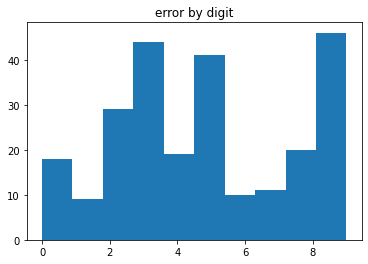

97.53% accuracy or 2.47% error rate


In [25]:
testmodel()